# General relativity using symbolic computer algebra

In order to perform symbolic manipulations, we use the `sympy` package together with the `gravipy` package. While the first one is a comprehensive package for symbolic computer algebra, the latter is a small package providing in particular a few tensors needed in the context of general relativity. `gravipy` is available from the [pypi repository](https://pypi.org/project/GraviPy/) while a good way to have access to the `sympy` package is through an installation of the free [Anaconda distribution](https://www.anaconda.com/download/). As `gravipy` ensures that `sympy` is imported, it is sufficient to import only `gravipy` in the following cell.

In [1]:
from gravipy import *
init_printing()

## Derivation of the Schwarzschild solution

We choose as our coordinates $t, r, \theta,$ and $\phi$:

In [2]:
t, r, theta, phi = symbols(r't, r, \theta, \phi')
x = Coordinates('x', [t, r, theta, phi])
x.c

The line element is chosen to be of the form
$$\mathrm{d}s^2 = -A(r)c^2\mathrm{d}t^2+B(r)\mathrm{d}r^2+r^2\mathrm{d}\theta^2+r^2\sin(\theta)^2\mathrm{d}\phi^2$$
where we need to determine the functions $\alpha$ and $\beta$ as a function of the radial coordinate $r$.

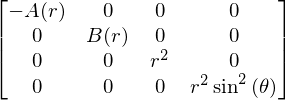

In [3]:
A, B = symbols('A, B')
Metric = diag(-A(r), B(r), r**2, r**2*sin(theta)**2)
g = MetricTensor('g', x, Metric)
g(All, All)

We are searching for a solution valid in the source-free region of space, i.e., we are looking for solutions of
$$G=0$$
where $G$ is the Einstein tensor. The ``gravipy`` package requires to first determine the Christoffel symbols and the Ricci tensor.

In [4]:
Ga = Christoffel('Ga', g)
Ric = Ricci('Ric', g)
Einst = Einstein('Einst', Ric)

The Einstein tensor is obtained as

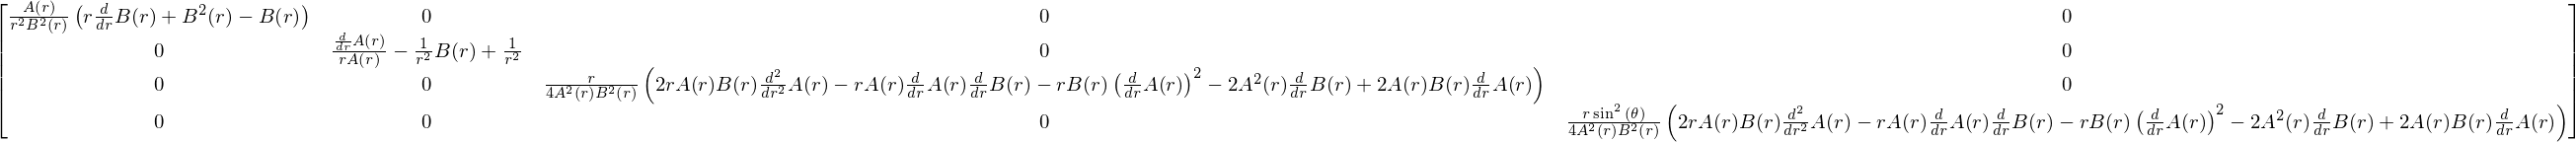

In [5]:
Einst(All, All)

It turns out that $G_{22}$ and $G_{33}$ are trivially related by a factor $\sin(\theta)^2$, so that it is sufficient to 
solve the set of equations
$$G_{00}=0,\quad G_{11}=0,\quad G_{22}=0.$$
We note that the first equation essentially depends only on $B(r)$. Therefore, we start by solving this equation. In order to ensure that for $r\to\infty$ we obtain the Minkowski metric, we divide the solution by the corresponding limit:

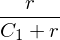

In [6]:
B_solution = dsolve(Einst(1, 1), B(r)).rhs
B_solution = B_solution/limit(B_solution, r, oo)
B_solution

In the next step, we use this result to solve the second equation for the function $A(r)$:

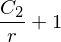

In [7]:
A_solution = dsolve(Einst(2, 2).subs(B(r), B_solution), A(r)).rhs
A_solution = A_solution/limit(A_solution, r, oo)
A_solution

We are thus left with two constants $C_1$ and $C_2$ which have to be chose such that they satisfy the third equation:

In [8]:
C1, C2 = symbols('C1, C2')
C_solution = solve(Einst(3, 3).subs(A(r), A_solution).subs(B(r), B_solution).doit(), C1, C2, dict=True)
C_solution

It turns out that $C_1\overset{!}{=}C_2$, which we insert into the solution for $B(r)$.

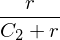

In [9]:
B_solution = B_solution.subs(C_solution[0])
B_solution

We are left with one free parameter which was to be expected because the mass $M$ of the central object should remain as a parameter. The parameter can be determined by comparing the spectral shift obtained from our solution with the spectral shift obtained from the Newtonian gravitational field ad demanded by the equivalence principle. Assuming that the frequency $\nu(r)$ of a photon at radial coordinate $r$ is measured when its frequency at infinity was $\nu(\infty)$, we have
$$\frac{\nu(r)}{\nu(\infty)} = \frac{1}{\sqrt{-g_{00}}} \overset{!}{=} 1+\frac{GM}{c^2r}.$$

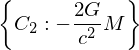

In [10]:
g00 = g(1, 1).subs(A(r), A_solution)
coeff_one_over_r = series(1/sqrt(-g00), 1/r, 0, 2).coeff(r, -1)
G, M, c = symbols('G, M, c')
c2_solution = solve(coeff_one_over_r-G*M/c**2, C2, dict=True)[0]
c2_solution

We thus obtain the functions $A(r)$ and $B(r)$ as

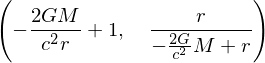

In [11]:
A_solution = A_solution.subs(c2_solution)
B_solution = B_solution.subs(c2_solution)
A_solution, B_solution

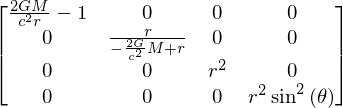

In [12]:
Metric = diag(-A_solution, B_solution, r**2, r**2*sin(theta)**2)
g = MetricTensor('g', x, Metric)
g(All, All)

With the Schwarzschild radius
$$r_\mathrm{S} = \frac{2GM}{c^2},$$
our final result for the Schwarzschild line element thus reads
$$\mathrm{d}s^2 = -\left(1-\frac{r_\text{S}}{r}\right)c^2\mathrm{d}t^2+\frac{1}{1-\frac{r_\text{S}}{r}}\mathrm{d}r^2+r^2\mathrm{d}\theta^2+r^2\sin(\theta)^2\mathrm{d}\phi^2.$$
The Einstein tensor indeed vanishes as it should:

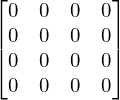

In [13]:
Ga = Christoffel('Ga', g)
Ric = Ricci('Ric', g)
Einst = Einstein('Einst', Ric)
Einst(All, All)

The Riemann tensor, on the other hand, contains non-vanishing elements. The space-time in the source-free region described by the Schwarzschild metric is thus curved.

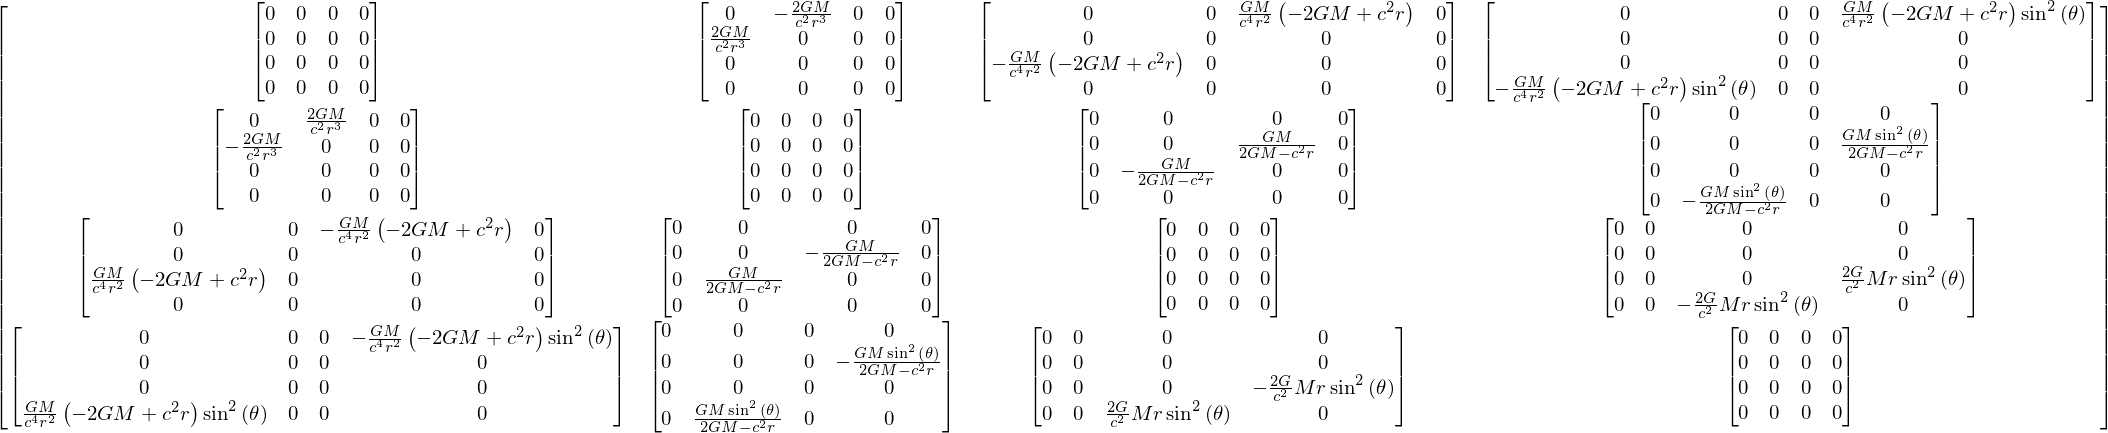

In [14]:
Rm = Riemann('Rm', g)
Rm(All, All, All, All)

The metric in the coordinates chosen here contains two singularities, namely at $r=0$ and $r=r_\mathrm{S}$. In order to decide which one of those is a real singularity, we determine the Kretschmann invariant
$$R_{\mu\nu\rho\sigma}R^{\mu\nu\rho\sigma}.$$
This quantity is independent of the chose coordinates

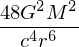

In [15]:
from itertools import product
Kretschmann = symbols('Kretschmann')
Kretschmann = 0
for mu, nu, rho, sigma in product(range(1, 5), repeat=4):
    Kretschmann = Kretschmann+Rm(mu, nu, rho, sigma)*Rm(-mu, -nu, -rho, -sigma)
simplify(Kretschmann)

Indeed, the only singularity of the Schwarzschild metric is found at $r=0$. The singularity at $r_\mathrm{S}$ can be removed by a appropriate choice of coordinates.

## Tolman-Oppenheimer-Volkoff equation

In [86]:
A = Function('A')
B = Function('B')
Metric = diag(-A(r), B(r), r**2, r**2*sin(theta)**2)
g = MetricTensor('g', x, Metric)
Ga = Christoffel('Ga', g)
Ric = Ricci('Ric', g)
Einst = Einstein('Einst', Ric)

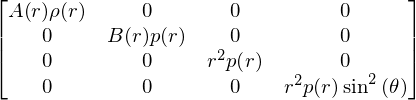

In [87]:
p, rho = symbols(r'p, \rho')
T = Tensor('T', 2, g,
           components=diag(A(r)*rho(r), B(r)*p(r), r**2*p(r), r**2*sin(theta)**2*p(r)))
T(All, All)

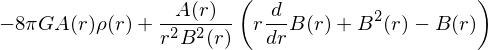

In [88]:
G = symbols('G')
Einst(1, 1)-8*pi*G*T(1, 1)

In [89]:
m = symbols('m')
b_solution = solve(m-(r-r/B(r))/(2*G), B(r), dict=True)[0]
Metric = diag(-A(r), B(r).subs(b_solution), r**2, r**2*sin(theta)**2)
g = MetricTensor('g', x, Metric)
Ga = Christoffel('Ga', g)
Ric = Ricci('Ric', g)
Einst = Einstein('Einst', Ric)
T = Tensor('T', 2, g,
           components=diag(A(r)*rho(r), B(r).subs(b_solution)*p(r), r**2*p(r), r**2*sin(theta)**2*p(r)))

In [90]:
Einst(1, 1)-8*pi*G*T(1, 1)

In [91]:
g

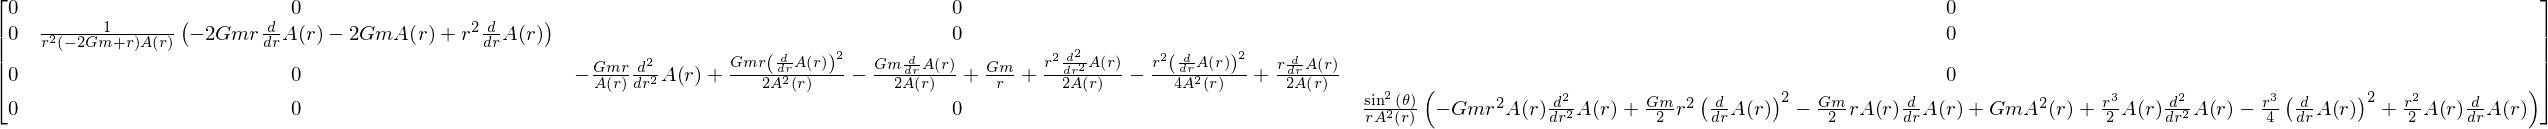

In [92]:
Einst(All, All)